In [91]:
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support.ui import Select
from datetime import datetime
from time import sleep
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import config

In [92]:
# disable notifications
chrome_options = Options()
chrome_options.add_argument("--disable-notifications")

In [93]:
# open the facebook group (Student Housing in Waterloo)
# NOTE: replace path_to_chromedriver with your own path
driver = webdriver.Chrome(config.path_to_chromedriver, options=chrome_options) 
driver.get("https://www.facebook.com")

/var/folders/jf/mzp0fx9j59z164nkct92ngcc0000gn/T/ipykernel_5130/2693793491.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(config.path_to_chromedriver, options=chrome_options)


In [94]:
# Log in using my credentials
username = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='email']")))
password = WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "input[name='pass']")))

# my_username and my_password should be replaced with your own unique values
username.clear()
username.send_keys(config.my_username) 
password.clear()
password.send_keys(config.my_password)
button = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "button[type='submit']"))).click()
sleep(8)

In [95]:
driver.get('https://www.facebook.com/groups/110354088989367')
sleep(8)

In [96]:
for j in range(0,40):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    sleep(5)

In [97]:
soup = BeautifulSoup(driver.page_source, "html.parser")
all_posts = soup.find_all('div', attrs={'class':'du4w35lb k4urcfbm l9j0dhe7 sjgh65i0'})

In [98]:
len(all_posts) # 282 posts when scrolled 50 times - range(0, 50)

219

In [99]:
def get_bedrooms(my_str):
    my_str = my_str.lower()
    d = re.search('([^ \r\n]+) bedrooms?([\r\n]| |$)', my_str)
    if d:
        found = d.group(0)
        return found
    else:
        return 1

In [100]:
price_list = []
bedrooms_list = []

In [168]:
for post in all_posts: 
    price_text = post.find('span', attrs={'class': 'sqxagodl'}).find('div').getText()
    price = ''.join([n for n in price_text.split()[0] if n.isdigit()])
    if not price: 
        price = 0
#     print(price, type(price))
    
    message = post.find('div', attrs={'class':'kvgmc6g5 cxmmr5t8 oygrvhab hcukyx3x c1et5uql ii04i59q'})
    if message: 
        message = str(message.getText())
    else:
        message = ''
        
    bedroom_text = get_bedrooms(message)
    bedroom = ''.join([n for n in str(bedroom_text).split()[0] if n.isdigit()])
    if not bedroom: 
        bedroom = 1
#     print('Number of bedrooms:', bedroom)

    price_list.append(int(price))
    bedrooms_list.append(int(bedroom))

In [156]:
price_list[:10], bedrooms_list[:10]

([400, 1, 1, 1, 750, 150, 750, 1, 0, 0], [1, 1, 1, 2, 1, 1, 1, 2, 1, 2])

In [157]:
len(price_list), len(bedrooms_list)

(438, 438)

In [158]:
data = {'price': price_list, 'bedroom': bedrooms_list}

In [159]:
[isinstance(item, int) for item in bedrooms_list[:5]]

[True, True, True, True, True]

In [160]:
df = pd.DataFrame(data)
df.to_excel('housing_list.xlsx', index=False)

In [161]:
df.groupby('bedroom').get_group(2)

,price,bedroom
3,1,2
7,1,2
9,0,2
10,1200,2
35,1,2
38,1000,2
50,1200,2
60,700,2
89,1,2
207,810,2


In [162]:
# by_bedroom = df.groupby('bedroom')
df.groupby('bedroom').describe()

price                                                           \
         count         mean           std    min    25%    50%      75%   
bedroom                                                                   
1        402.0  6124.039801  70898.602887    0.0    1.0  575.0   800.00   
2         22.0   446.818182    519.156242    0.0    1.0    1.0   952.50   
4          6.0  1670.833333   1304.359677  800.0  825.0  850.0  2618.75   
5          2.0   800.000000      0.000000  800.0  800.0  800.0   800.00   
12         2.0     1.000000      0.000000    1.0    1.0    1.0     1.00   
23         2.0   800.000000      0.000000  800.0  800.0  800.0   800.00   
33         2.0     1.000000      0.000000    1.0    1.0    1.0     1.00   

                   
              max  
bedroom            
1        999999.0  
2          1200.0  
4          3500.0  
5           800.0  
12            1.0  
23          800.0  
33            1.0

In [163]:
df.drop(df[(df.price < 300) | (df.price > 5000)].index, inplace=True)
df.drop(df[df.bedroom > 7].index, inplace=True)
# df.loc[df.my_channel > 20000, 'my_channel'] = 0

In [173]:
df.groupby('bedroom').describe()

price                                                            \
         count         mean          std    min     25%     50%      75%   
bedroom                                                                    
1        224.0   955.428571   538.085457  300.0  683.75   800.0  1012.50   
2         10.0   982.000000   213.166602  700.0  810.00  1000.0  1200.00   
4          6.0  1670.833333  1304.359677  800.0  825.00   850.0  2618.75   
5          2.0   800.000000     0.000000  800.0  800.00   800.0   800.00   

                 
            max  
bedroom          
1        3400.0  
2        1200.0  
4        3500.0  
5         800.0

In [174]:
by_bedroom = df.groupby('bedroom')

In [175]:
bedroom_labels = []
bedroom_values = []

price_by_bedroom = {}

In [176]:
by_bedroom

In [177]:
for idx, frame in by_bedroom:
    bedroom_labels.append(idx)
    bedroom_values.append(by_bedroom.size()[idx])
    
    price_by_bedroom[idx] = by_bedroom.mean().loc[idx, 'price']
#     print(f"{by_bedroom.get_group(idx)}")
#     print("------------------------")

In [178]:
price_by_bedroom

{1: 955.4285714285714, 2: 982.0, 4: 1670.8333333333333, 5: 800.0}

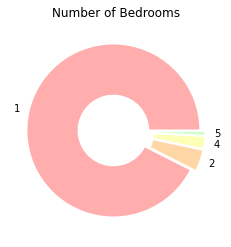

In [179]:
colors = ['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf']
explode = [0.03] * 4
wedgeprops = {'width': 0.6, 'edgecolor':'w', 'linewidth':2}
plt.pie(bedroom_values, labels=bedroom_labels, colors=colors, explode=explode, wedgeprops=wedgeprops)
plt.title("Number of Bedrooms")
plt.show()

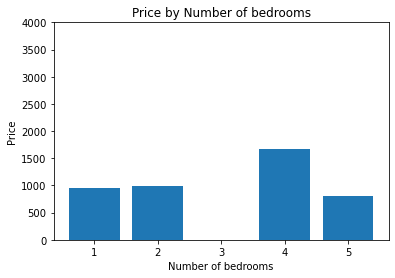

In [180]:
plt.bar(price_by_bedroom.keys(), price_by_bedroom.values())
plt.ylim(0, 4000)
plt.title("Price by Number of bedrooms")
plt.xlabel('Number of bedrooms')
plt.ylabel('Price')
plt.show()

#### other things to consider: 
- number of bedrooms
- number of washrooms 
- number of roommates
- location (how far from uw?)
